Sebastian Colorado Barrientos
1152471219

In [411]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


import statsmodels.api as sm
import math


#creación de modelos
from sklearn.ensemble import RandomForestClassifier


import multiprocessing

#evaluacion de variables
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RepeatedKFold
from sklearn.inspection import permutation_importance
from sklearn import metrics

#from sklearn.metrics import accuracy_score

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
#
#from sklearn.model_selection import GridSearchCV

#


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [412]:
# Función para contruir un modelo de regresión lineal por medio de statsmodels.api

def build_model(X,y):
    #A los datos de entrada 'X' se le adiciona una constante
    X = sm.add_constant(X)
    #Se crea y se entrena el modelo de regresion lineal q(statsmodels.api) con
    #los datos de entrada 'X' y los datos de salida 'y'
    lm = sm.OLS(y,X).fit()
    #imprime el resumen del modelo creado
    print(lm.summary()) # model summary
    return X

In [413]:
#Función para calcular VIF (Variance Inflation Factor):

#Se Utiliza VIF para solucionar la multicolinealidad. VIF indica el grado de indecencia de esa variable.
#Los valores de los umbrales típicos que se suelen utilizar son entre 5 y 10, siendo más exigentes los valores más bajos.

def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

Extracción de datos

In [414]:
df = pd.read_csv('games.csv')
games_delay_in_sec = (df['last_move_at'] - df['created_at']) / 1000
df['duration_in_seconds'] = games_delay_in_sec.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   20058 non-null  object 
 1   rated                20058 non-null  bool   
 2   created_at           20058 non-null  float64
 3   last_move_at         20058 non-null  float64
 4   turns                20058 non-null  int64  
 5   victory_status       20058 non-null  object 
 6   winner               20058 non-null  object 
 7   increment_code       20058 non-null  object 
 8   white_id             20058 non-null  object 
 9   white_rating         20058 non-null  int64  
 10  black_id             20058 non-null  object 
 11  black_rating         20058 non-null  int64  
 12  moves                20058 non-null  object 
 13  opening_eco          20058 non-null  object 
 14  opening_name         20058 non-null  object 
 15  opening_ply          20058 non-null 

Limpieza de los datos

In [415]:
minutes = df['increment_code'].str.split('+').map(lambda time_control: time_control[0], na_action=None).astype(int)
incr_seconds = df['increment_code'].str.split('+').map(lambda time_control: time_control[1], na_action=None).astype(int)

df['minutes'] = minutes.copy()
df['incr_seconds'] = incr_seconds.copy()

In [416]:
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')

In [417]:
max_minutes = df['minutes'].max()
max_incr_seconds = df['incr_seconds'].max()
mean_moves = df['turns'].mean()
duration_threshold_in_hours = (max_minutes + max_incr_seconds / 60 * mean_moves) / 60
duration_threshold_in_hours

6.0232999302024135

In [418]:
df = df[df['turns'] > 3]
df = df[df['duration_in_seconds'] < duration_threshold_in_hours * 3600]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19766 entries, 0 to 20057
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   19766 non-null  object        
 1   rated                19766 non-null  bool          
 2   created_at           19766 non-null  datetime64[ns]
 3   last_move_at         19766 non-null  datetime64[ns]
 4   turns                19766 non-null  int64         
 5   victory_status       19766 non-null  object        
 6   winner               19766 non-null  object        
 7   increment_code       19766 non-null  object        
 8   white_id             19766 non-null  object        
 9   white_rating         19766 non-null  int64         
 10  black_id             19766 non-null  object        
 11  black_rating         19766 non-null  int64         
 12  moves                19766 non-null  object        
 13  opening_eco          19766 non-

In [419]:
duration0 = df[df['duration_in_seconds'] == 0]
duration0['winner'].value_counts()

white    4207
black    3910
draw      355
Name: winner, dtype: int64

In [420]:
df = df[df['duration_in_seconds'] > 0]

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11294 entries, 14 to 20057
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   11294 non-null  object        
 1   rated                11294 non-null  bool          
 2   created_at           11294 non-null  datetime64[ns]
 3   last_move_at         11294 non-null  datetime64[ns]
 4   turns                11294 non-null  int64         
 5   victory_status       11294 non-null  object        
 6   winner               11294 non-null  object        
 7   increment_code       11294 non-null  object        
 8   white_id             11294 non-null  object        
 9   white_rating         11294 non-null  int64         
 10  black_id             11294 non-null  object        
 11  black_rating         11294 non-null  int64         
 12  moves                11294 non-null  object        
 13  opening_eco          11294 non

In [422]:
df['winner'].unique()

array(['white', 'black', 'draw'], dtype=object)

In [423]:
df['winner'].value_counts()

white    5639
black    5074
draw      581
Name: winner, dtype: int64

In [424]:
df['opening_eco'].value_counts()

A00    537
C00    457
C41    411
D00    386
A40    346
      ... 
B60      1
A65      1
E72      1
C09      1
D19      1
Name: opening_eco, Length: 344, dtype: int64

In [425]:
frecuencia_aperturas = df['opening_eco'].value_counts()
aperturas_frecuentes = frecuencia_aperturas[frecuencia_aperturas > 100].index
df = df[df['opening_eco'].isin(aperturas_frecuentes)]

In [426]:
df['opening_eco'].value_counts()

A00    537
C00    457
C41    411
D00    386
A40    346
C20    336
B01    331
C50    330
B20    309
B00    292
C40    238
D02    236
C44    208
C42    190
C55    182
B07    176
C45    175
C02    161
A04    156
A45    155
B50    139
C46    133
D20    130
B21    125
B10    122
B12    119
B30    117
C21    108
B06    103
Name: opening_eco, dtype: int64

In [427]:
df = df[df['winner'] != 'draw']

In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6406 entries, 14 to 20057
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   6406 non-null   object        
 1   rated                6406 non-null   bool          
 2   created_at           6406 non-null   datetime64[ns]
 3   last_move_at         6406 non-null   datetime64[ns]
 4   turns                6406 non-null   int64         
 5   victory_status       6406 non-null   object        
 6   winner               6406 non-null   object        
 7   increment_code       6406 non-null   object        
 8   white_id             6406 non-null   object        
 9   white_rating         6406 non-null   int64         
 10  black_id             6406 non-null   object        
 11  black_rating         6406 non-null   int64         
 12  moves                6406 non-null   object        
 13  opening_eco          6406 non-n

In [429]:
df = pd.get_dummies(df, columns=['opening_eco'])

In [430]:
df = pd.get_dummies(df, columns=['victory_status'])

In [431]:
df = df.drop('id', axis=1)
df = df.drop('rated', axis=1)
df = df.drop('created_at', axis=1)
df = df.drop('last_move_at', axis=1)
df = df.drop('increment_code', axis=1)
df = df.drop('white_id', axis=1)
df = df.drop('black_id', axis=1)
df = df.drop('moves', axis=1)
df = df.drop('opening_name', axis=1)
df = df.drop('minutes', axis=1)
df = df.drop('incr_seconds', axis=1)
df = df.drop('duration_in_seconds', axis=1)

In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6406 entries, 14 to 20057
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   turns                     6406 non-null   int64 
 1   winner                    6406 non-null   object
 2   white_rating              6406 non-null   int64 
 3   black_rating              6406 non-null   int64 
 4   opening_ply               6406 non-null   int64 
 5   opening_eco_A00           6406 non-null   uint8 
 6   opening_eco_A04           6406 non-null   uint8 
 7   opening_eco_A40           6406 non-null   uint8 
 8   opening_eco_A45           6406 non-null   uint8 
 9   opening_eco_B00           6406 non-null   uint8 
 10  opening_eco_B01           6406 non-null   uint8 
 11  opening_eco_B06           6406 non-null   uint8 
 12  opening_eco_B07           6406 non-null   uint8 
 13  opening_eco_B10           6406 non-null   uint8 
 14  opening_eco_B12       

In [433]:
X = df.drop('winner', axis=1)
y = df['winner']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.8)

In [434]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1281, 36), (5125, 36), (1281,), (5125,))

In [435]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [200],
                 'max_features': [9,11,13,15],
                 'max_depth'   : [None, 3, 10, 20, 40],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:


    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train, y_train)


    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 11, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 13, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 15, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 11, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 13, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 15, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 11, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 13, 'n_estimators': 200} ✓
Modelo: {

In [436]:
resultados.head()

,oob_accuracy,criterion,max_depth,max_features,n_estimators
37,0.645589,entropy,40.0,11,200
39,0.644028,entropy,40.0,15,200
10,0.644028,gini,10.0,13,200
23,0.643247,entropy,NaN,15,200
33,0.641686,entropy,20.0,11,200


In [437]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [200],
                 'max_features': [9,11,13,15],
                 'max_depth'   : [None, 3, 10, 20, 40],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
21,entropy,None,11,200,0.644036,0.021879,1.000000,0.000000
37,entropy,40,11,200,0.643254,0.021637,1.000000,0.000000
30,entropy,10,13,200,0.643227,0.024427,0.915691,0.005538
31,entropy,10,15,200,0.642461,0.023594,0.922716,0.005077


In [438]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'entropy', 'max_depth': None, 'max_features': 11, 'n_estimators': 200} : 0.6440357490272374 accuracy


In [439]:
modelo_final = grid.best_estimator_

In [440]:
# Error de test del modelo final
# ==============================================================================
y_pred = modelo_final.predict(X_test)

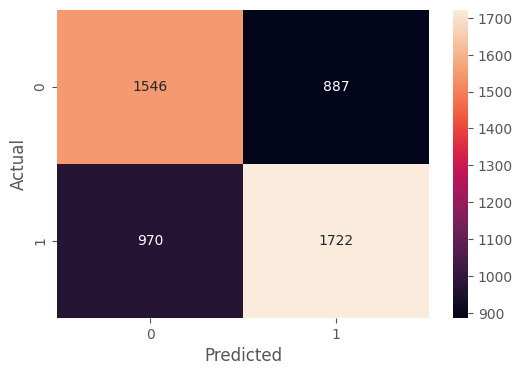

              precision    recall  f1-score   support

       black       0.61      0.64      0.62      2433
       white       0.66      0.64      0.65      2692

    accuracy                           0.64      5125
   macro avg       0.64      0.64      0.64      5125
weighted avg       0.64      0.64      0.64      5125



In [441]:
# Crear matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(6,4))

# Crear mapa de calor de la matriz de confusión con Seaborn
sns.heatmap(conf_mat
            , annot=True  # agregar valores en cada celda
            , fmt='d'    # formato de los valores (d = decimal)
           )

# Agregar etiquetas a los ejes x e y
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Mostrar la figura
plt.show()

# Se imprimen las medidas de rendimiento del modelo
print(metrics.classification_report(y_test, y_pred))